In [3]:
!pip3 install opencv-contrib-python

  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl (44.2 MB)


In [33]:
import numpy as np
import os
import random
import torch
from torch import nn
import torch.nn.functional as F
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from vit import ViT
from train_vit import set_seed, prepare_dataloaders
import cv2



In [34]:
# set the seed
set_seed(1)

# prepare the dataloaders
trainloader, testloader, trainset, testset = prepare_dataloaders(batch_size=1)

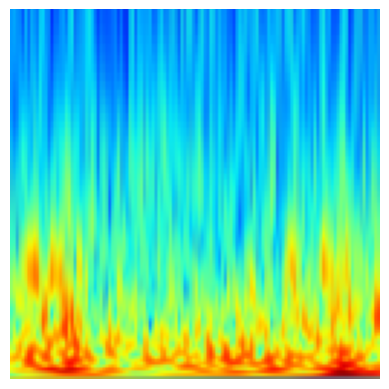

In [35]:
# get the image
# image, label = trainset[9]
image, label = trainset[12]

# visualize the image
# img_grid = torchvision.utils.make_grid(image, normalize=True, pad_value=0.9)
img_grid = image.permute(1, 2, 0)
plt.imshow(img_grid)
plt.axis("off")
plt.show()


In [36]:
# load the model
model = torch.load("model.pth").to("cpu")
transform = transforms.Compose(
    [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [37]:
image.size()

torch.Size([3, 128, 128])

In [38]:
x = transform(image).unsqueeze(0)
result, att_mat_list = model(image.unsqueeze(0))
print("layer num:", len(att_mat_list))
print("att_mat size:", att_mat_list[0].size())

layer num: 4
att_mat size: torch.Size([4, 65, 65])


In [39]:
att_matrices = torch.stack(att_mat_list)
print(att_matrices.size())
# att_matrices = att_matrices.mean(dim=1)
att_matrices, _ = att_matrices.min(dim=1)
att_matrices

torch.Size([4, 4, 65, 65])


tensor([[[1.6273e-04, 1.9471e-05, 3.2027e-04,  ..., 1.5790e-04,
          5.5579e-05, 1.1580e-05],
         [1.1402e-03, 7.6377e-04, 7.5308e-03,  ..., 1.0731e-03,
          2.6308e-04, 1.4556e-04],
         [1.7469e-03, 1.7662e-03, 5.4079e-03,  ..., 1.4160e-03,
          2.3779e-03, 7.5935e-04],
         ...,
         [2.4309e-04, 1.1161e-03, 1.9554e-03,  ..., 4.4293e-04,
          8.1464e-04, 2.4489e-04],
         [2.5378e-04, 1.9856e-03, 1.1445e-03,  ..., 2.9343e-04,
          6.4184e-04, 1.0474e-04],
         [1.2296e-03, 9.7498e-03, 6.0600e-03,  ..., 2.4372e-03,
          2.6602e-03, 1.1676e-03]],

        [[4.0833e-03, 1.1496e-02, 2.1141e-02,  ..., 2.0693e-04,
          2.2587e-04, 4.1991e-05],
         [6.0793e-03, 1.2378e-02, 1.4150e-02,  ..., 5.5044e-03,
          3.6266e-03, 8.4771e-03],
         [8.1444e-03, 1.0319e-02, 1.1506e-02,  ..., 8.9233e-03,
          6.0979e-03, 1.7436e-02],
         ...,
         [9.6944e-03, 2.1624e-03, 3.4760e-03,  ..., 1.5703e-03,
          2.483

In [40]:
att_matrices = torch.stack(att_mat_list)
print(att_matrices.size())
# att_matrices = att_matrices.mean(dim=1)
# att_matrices, _ = att_matrices.min(dim=1)
att_matrices, _ = att_matrices.max(dim=1)
print(att_matrices.size())
residual_att = torch.eye(att_matrices.size(1))
print(residual_att.size())
aug_att_matrices = att_matrices + residual_att
print(aug_att_matrices.sum(dim=-1).unsqueeze(-1).size())
aug_att_matrices = aug_att_matrices / aug_att_matrices.sum(dim=-1).unsqueeze(-1)


torch.Size([4, 4, 65, 65])
torch.Size([4, 65, 65])
torch.Size([65, 65])
torch.Size([4, 65, 1])


In [41]:
roll_out_atts = torch.zeros(aug_att_matrices.size())
roll_out_atts[0] = aug_att_matrices[0]

for n in range(1, aug_att_matrices.size(0)):
    roll_out_atts[n] = torch.matmul(aug_att_matrices[n], roll_out_atts[n-1])

v = roll_out_atts[-1]
grid_size = int(np.sqrt(aug_att_matrices.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), (128, 128))[..., np.newaxis]
print(v[0, 1:].shape)
print(mask.shape)
print(mask)

torch.Size([64])
(128, 128, 1)
[[[0.20114443]
  [0.20114443]
  [0.20114443]
  ...
  [0.14626175]
  [0.14626175]
  [0.14626175]]

 [[0.20114443]
  [0.20114443]
  [0.20114443]
  ...
  [0.14626175]
  [0.14626175]
  [0.14626175]]

 [[0.20114443]
  [0.20114443]
  [0.20114443]
  ...
  [0.14626175]
  [0.14626175]
  [0.14626175]]

 ...

 [[0.12393183]
  [0.12393183]
  [0.12393183]
  ...
  [0.15697642]
  [0.15697642]
  [0.15697642]]

 [[0.12393183]
  [0.12393183]
  [0.12393183]
  ...
  [0.15697642]
  [0.15697642]
  [0.15697642]]

 [[0.12393183]
  [0.12393183]
  [0.12393183]
  ...
  [0.15697642]
  [0.15697642]
  [0.15697642]]]


In [42]:
max_result = (image.permute(1, 2, 0).numpy()*255.0*mask).astype(np.uint8)

In [43]:
# result = (mask * image.permute(1, 2, 0).numpy() + (1 - mask) * 255).astype(np.uint8)
min_result = (image.permute(1, 2, 0).numpy()*255.0*mask).astype(np.uint8)

# print(result)

In [44]:
# print(image.permute(1, 2, 0).numpy()*255.0)
mean_result = (image.permute(1, 2, 0).numpy()*255.0*mask).astype(np.uint8)

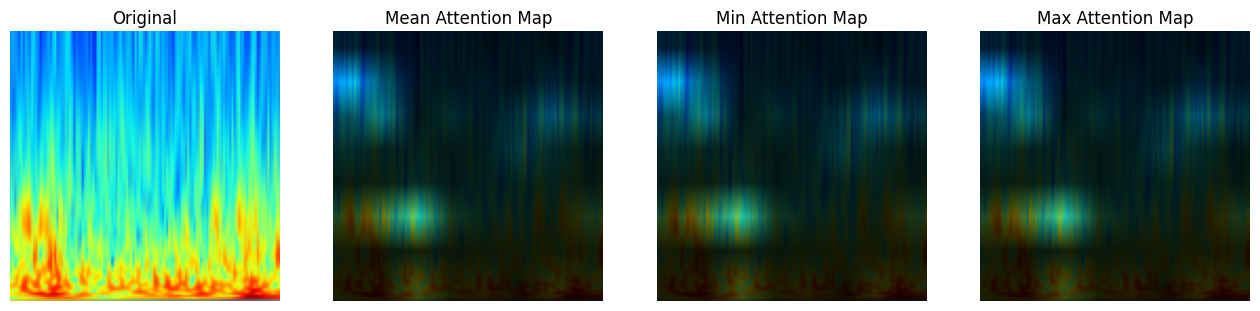

In [45]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Mean Attention Map')
ax3.set_title('Min Attention Map')
ax4.set_title('Max Attention Map')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
_ = ax1.imshow(image.permute(1, 2, 0))
_ = ax2.imshow(mean_result)
_ = ax3.imshow(min_result)
_ = ax4.imshow(max_result)

(-0.5, 127.5, 127.5, -0.5)

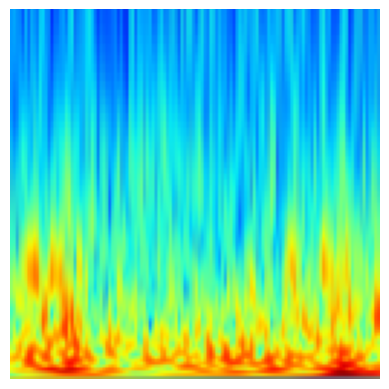

In [46]:
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')